# Instruments and pricing engines

In this notebook, I'll show how instruments and their available engines can monitor changes in their input data.

#### Setup

To begin, we import the QuantLib module and set up the global evaluation date.

In [1]:
from QuantLib import *

In [2]:
today = Date(7, March, 2014)
Settings.instance().evaluationDate = today

#### The instrument

As a sample instrument, we'll take a textbook example: a European option.

Building the option requires only the specification of its contract, so its payoff (it's a call option with strike at 100) and its exercise, three months from today's date. Market data will be selected and passed later, depending on the calculation methods.

In [3]:
option = EuropeanOption(PlainVanillaPayoff(Option.Call, 100.0),
                        EuropeanExercise(Date(7, June, 2014)))

#### First pricing method: analytic Black-Scholes formula

The different pricing methods are implemented as pricing engines holding the required market data. The first we'll use is the one encapsulating the analytic Black-Scholes formula.

First, we collect the quoted market data.  We'll assume flat risk-free rate and volatility, so they can be expressed by `SimpleQuote` instances: those model numbers whose value can change and that can notify observers when this happens.  The underlying value is at 100, the risk-free value at 1%, and the volatility at 20%.

In [4]:
u = SimpleQuote(100.0)
r = SimpleQuote(0.01)
sigma = SimpleQuote(0.20)

In order to build the engine, the market data are encapsulated in a Black-Scholes process object.  First we build flat curves for the risk-free rate and the volatility...

In [5]:
riskFreeCurve = FlatForward(0, TARGET(), QuoteHandle(r), Actual360())
volatility = BlackConstantVol(0, TARGET(), QuoteHandle(sigma), Actual360())

...then we instantiate the process with the underlying value and the curves we just built.  The inputs are all stored into handles, so that we could change the quotes and curves used if we wanted.  I'll skip over this for the time being.

In [6]:
process = BlackScholesProcess(QuoteHandle(u),
                              YieldTermStructureHandle(riskFreeCurve),
                              BlackVolTermStructureHandle(volatility))

Once we have the process, we can finally use it to build the engine...

In [7]:
engine = AnalyticEuropeanEngine(process)

...and once we have the engine, we can set it to the option and evaluate the latter.

In [8]:
option.setPricingEngine(engine)

In [9]:
print(option.NPV())

4.155543462156206


Depending on the instrument and the engine, we can also ask for other results; in this case, we can ask for Greeks.

In [10]:
print(option.delta())
print(option.gamma())
print(option.vega())

0.5302223303784392
0.03934493301271913
20.109632428723106


#### Market changes

As I mentioned, market data are stored in `Quote` instances and thus can notify the option when any of them changes.  We don't have to do anything explicitly to tell the option to recalculate: once we set a new value to the underlying, we can simply ask the option for its NPV again and we'll get the updated value.

In [11]:
u.setValue(105.0)
print(option.NPV())

7.27556357927846


Just for showing off, we can use this to graph the option value depending on the underlying asset value.  After a bit of graphic setup (don't pay attention to the man behind the curtains)...

In [12]:
%matplotlib inline
import numpy as np
from IPython.display import display
import utils

...we can take an array of values from 80 to 120, set the underlying value to each of them, collect the corresponding option values, and plot the results.

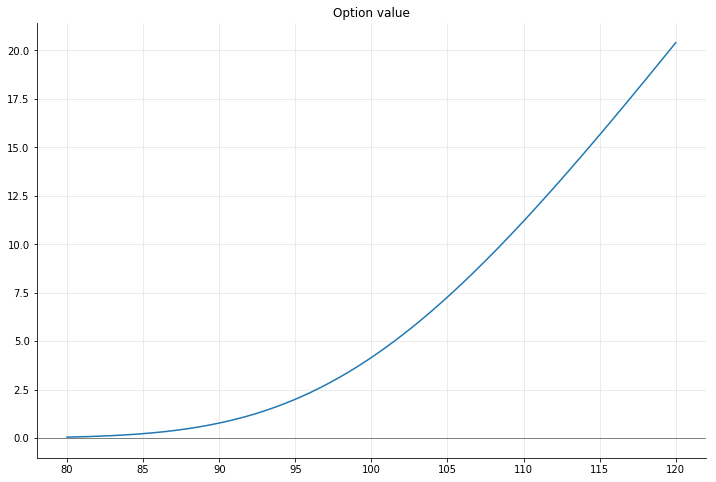

In [13]:
f, ax = utils.plot()
xs = np.linspace(80.0, 120.0, 400)
ys = []
for x in xs:
    u.setValue(x)
    ys.append(option.NPV())
ax.set_title('Option value')
utils.highlight_x_axis(ax)
ax.plot(xs, ys);

Other market data also affect the value, of course.

In [14]:
u.setValue(105.0)
r.setValue(0.01)
sigma.setValue(0.20)

In [15]:
print(option.NPV())

7.27556357927846


We can see it when we change the risk-free rate...

In [16]:
r.setValue(0.03)

In [17]:
print(option.NPV())

7.624029148527754


...or the volatility.

In [18]:
sigma.setValue(0.25)

In [19]:
print(option.NPV())

8.531296969971573


#### Date changes

Just as it does when inputs are modified, the value also changes if we advance the evaluation date.  Let's look first at the value of the option when its underlying is worth 105 and there's still three months to exercise...

In [20]:
u.setValue(105.0)
r.setValue(0.01)
sigma.setValue(0.20)
print(option.NPV())

7.27556357927846


...and then move to a date two months before exercise.

In [21]:
Settings.instance().evaluationDate = Date(7, April, 2014)

Again, we don't have to do anything explicitly: we just ask the option its value, and as expected it has decreased, as can also be seen by updating the plot.

In [22]:
print(option.NPV())

6.560073820974377


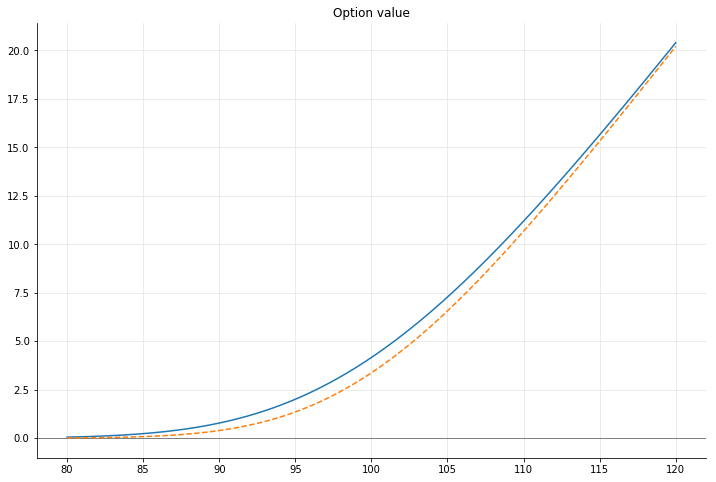

In [23]:
ys = []
for x in xs:
    u.setValue(x)
    ys.append(option.NPV())
ax.plot(xs, ys, '--')
display(f)

In the default library configuration, the returned value goes down to 0 when we reach the exercise date.

In [24]:
Settings.instance().evaluationDate = Date(7, June, 2014)

In [25]:
print(option.NPV())

0.0


#### Other pricing methods

The pricing-engine mechanism allows us to use different pricing methods.  For comparison, I'll first set the input data back to what they were previously and output the Black-Scholes price.

In [26]:
Settings.instance().evaluationDate = today
u.setValue(105.0)
r.setValue(0.01)
sigma.setValue(0.20)

In [27]:
print(option.NPV())

7.27556357927846


Let's say that we want to use a Heston model to price the option.  What we have to do is to instantiate the corresponding class with the desired inputs...

In [28]:
model = HestonModel(
    HestonProcess(YieldTermStructureHandle(riskFreeCurve),
                  YieldTermStructureHandle(FlatForward(0, TARGET(),
                                                       0.0, Actual360())),
                  QuoteHandle(u),
                  0.04, 0.1, 0.01, 0.05, -0.75))

...pass it to the corresponding engine, and set the new engine to the option.

In [29]:
engine = AnalyticHestonEngine(model)
option.setPricingEngine(engine)

Asking the option for its NPV will now return the value according to the new model.

In [30]:
print(option.NPV())

7.295356086978629


#### Lazy recalculation

One last thing.  Up to now, we haven't really seen evidence of notifications going around.  After all, the instrument might just have recalculated its value every time, regardless of notifications.  What I'm going to show, instead, is that the option doesn't just recalculate every time anything changes; it also avoids recalculations when nothing has changed.

We'll switch to a Monte Carlo engine, which takes a few seconds to run the required simulation.

In [31]:
engine = MCEuropeanEngine(process, "PseudoRandom",
                          timeSteps=20,
                          requiredSamples=250000)
option.setPricingEngine(engine)

When we ask for the option value, we have to wait for the calculation to finish...

In [32]:
%time print(option.NPV())

7.306010762284822
CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 1.71 s


...but a second call to the `NPV` method will be instantaneous when made before anything changes.  In this case, the option didn't calculate its value; it just returned the result that it cached from the previous call.

In [33]:
%time print(option.NPV())

7.306010762284822
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 976 µs


If we change anything (e.g., the underlying value)...

In [34]:
u.setValue(104.0)

...the option is notified of the change, and the next call to `NPV` will again take a while.

In [35]:
%time print(option.NPV())

6.597869654923489
CPU times: user 1.69 s, sys: 30 ms, total: 1.72 s
Wall time: 1.71 s
